In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab df/campaign_data.csv")

In [ ]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


# Data Preprocessing

In [ ]:
data.isna().any()

recency          False
history          False
used_discount    False
used_bogo        False
zip_code         False
is_referral      False
channel          False
offer            False
conversion       False
dtype: bool

In [ ]:
data.offer.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [ ]:
data["treatment"] = 0
data["treatment"] = data["treatment"].where(data["offer"]=="No Offer",1)

In [ ]:
data_feature = data.iloc[:,0:7]
data_treatment = data["treatment"]
data_target = data["conversion"]

In [ ]:
for i, col in enumerate(data_feature.columns):
    if data_feature[col].nunique() > 5:
        ss = StandardScaler()
        data_feature[col] = ss.fit_transform(data_feature[[col]])  
    else:
        data_feature[col] = data_feature[col].astype("category")
    print(col,data_feature[col].nunique(),data_feature.dtypes[i])

recency 12 float64
history 34833 float64
used_discount 2 category
used_bogo 2 category
zip_code 3 category
is_referral 2 category
channel 3 category


In [ ]:
data_feature.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,1.207751,-0.389003,1,0,Surburban,0,Phone
1,0.067359,0.339614,1,1,Rural,1,Web
2,0.352457,-0.239836,0,1,Surburban,1,Web
3,0.922653,1.693278,1,0,Rural,1,Web
4,-1.073034,-0.768068,1,0,Urban,0,Web


# Modeling

In [ ]:
!pip install scikit-uplift
!pip install scikit-optimize

In [ ]:
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve, plot_uplift_preds
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
from scipy.stats import reciprocal
from skopt import BayesSearchCV

In [ ]:
stratify_cols = pd.concat([data_treatment, data_target], axis=1)

X_cv, X_test, y_cv, y_test, trmnt_cv, trmnt_test = train_test_split(
    data_feature,
    data_target,
    data_treatment,
    stratify=stratify_cols,
    test_size=0.2,
    random_state=42
)

# setting up model ...
estimator = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
)


slearner = SoloModel(estimator=estimator)

# uplift metric scorer to pass to cross validation
uplift_scorer = make_uplift_scorer("qini_auc_score", trmnt_cv)

cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=42
)

In [ ]:
# use BayesSearch
space = {
    'estimator__learning_rate': [10**i for i in range(-3, 0)],
    'estimator__max_depth': list(range(3,11)),
    'estimator__n_estimators':list(range(100,500,50)), 
    'estimator__colsample_bytree':[0.5, 0.7]
}


bayes_search = BayesSearchCV(slearner,
                           search_spaces=space,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True,
                           n_iter=60
                          )


bayes_search = bayes_search.fit(
    X=X_cv,
    y=y_cv,
    treatment=trmnt_cv
)

In [29]:
print(f"best qini score on grid search: {bayes_search.best_score_:.4f}")
print(f"best params: {bayes_search.best_params_}")

best qini score on grid search: 0.0313
best params: OrderedDict([('estimator__colsample_bytree', 0.5985945239783924), ('estimator__learning_rate', 0.1), ('estimator__max_depth', 10), ('estimator__n_estimators', 100)])


In [30]:
slearner.set_params(**bayes_search.best_params_)

slearner.fit(
    X=X_cv, 
    y=y_cv, 
    treatment=trmnt_cv,
)

uplift = slearner.predict(X_test)

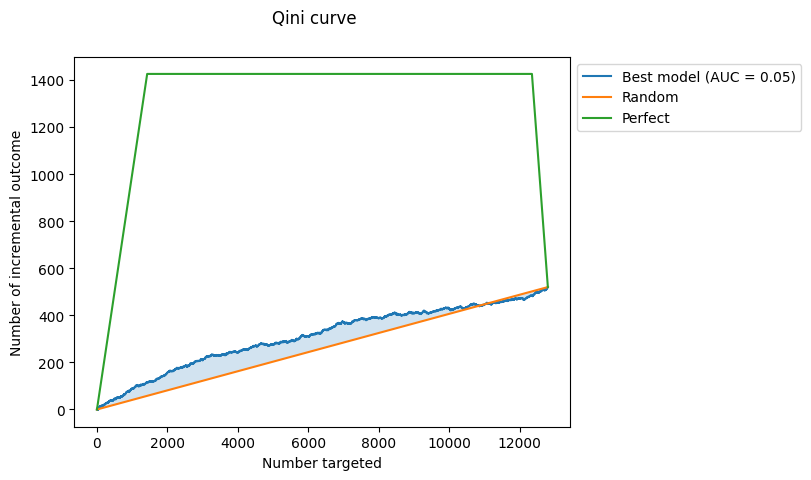

In [41]:
# model evaluation
bets_disp = plot_qini_curve(y_test, uplift, trmnt_test, perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");

In [32]:
# feature importance
df_imp = pd.DataFrame({
            "feature_name": slearner.estimator.feature_name_,
            "feature_importance": slearner.estimator.feature_importances_}).\
                sort_values("feature_importance", ascending=False).reset_index(drop=True)
df_imp

,feature_name,feature_importance
0,history,1216
1,recency,601
2,channel,297
3,zip_code,220
4,used_discount,186
5,used_bogo,178
6,treatment,163
7,is_referral,139


In [33]:
prob_treat = slearner.trmnt_preds_
prob_control = slearner.ctrl_preds_

# uplift by customer
dfZ = pd.DataFrame()
dfZ["prob_treat"] = prob_treat   
dfZ["prob_control"] = prob_control
dfZ["uplift"] = uplift
dfZ["y"] = y_test.values
dfZ["treatment"] = trmnt_test.values
dfZ.sort_values("uplift", inplace=True, ascending=False)   

# classify customers by their response probabilities
cutbins = [-1, -0.01, 0.01, 1]
cutlabels = ["sleeping dog", "sure thing", "persuadable"]
dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


# sure things needs to be split between lost causes and real sure things
dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"

In [34]:
dfZ.sort_values("uplift", ascending=False)

,prob_treat,prob_control,uplift,y,treatment,cats
1912,0.452690,0.111362,0.341327,1,1,persuadable
7209,0.375366,0.105655,0.269711,1,1,persuadable
12416,0.375366,0.105655,0.269711,0,1,persuadable
3969,0.371712,0.110804,0.260908,1,1,persuadable
5482,0.378527,0.118831,0.259697,0,1,persuadable
...,...,...,...,...,...,...
5747,0.183783,0.259230,-0.075446,1,1,sleeping dog
6730,0.218921,0.296189,-0.077268,0,1,sleeping dog
11837,0.116894,0.194898,-0.078005,0,1,sleeping dog
10364,0.162313,0.242943,-0.080630,1,1,sleeping dog


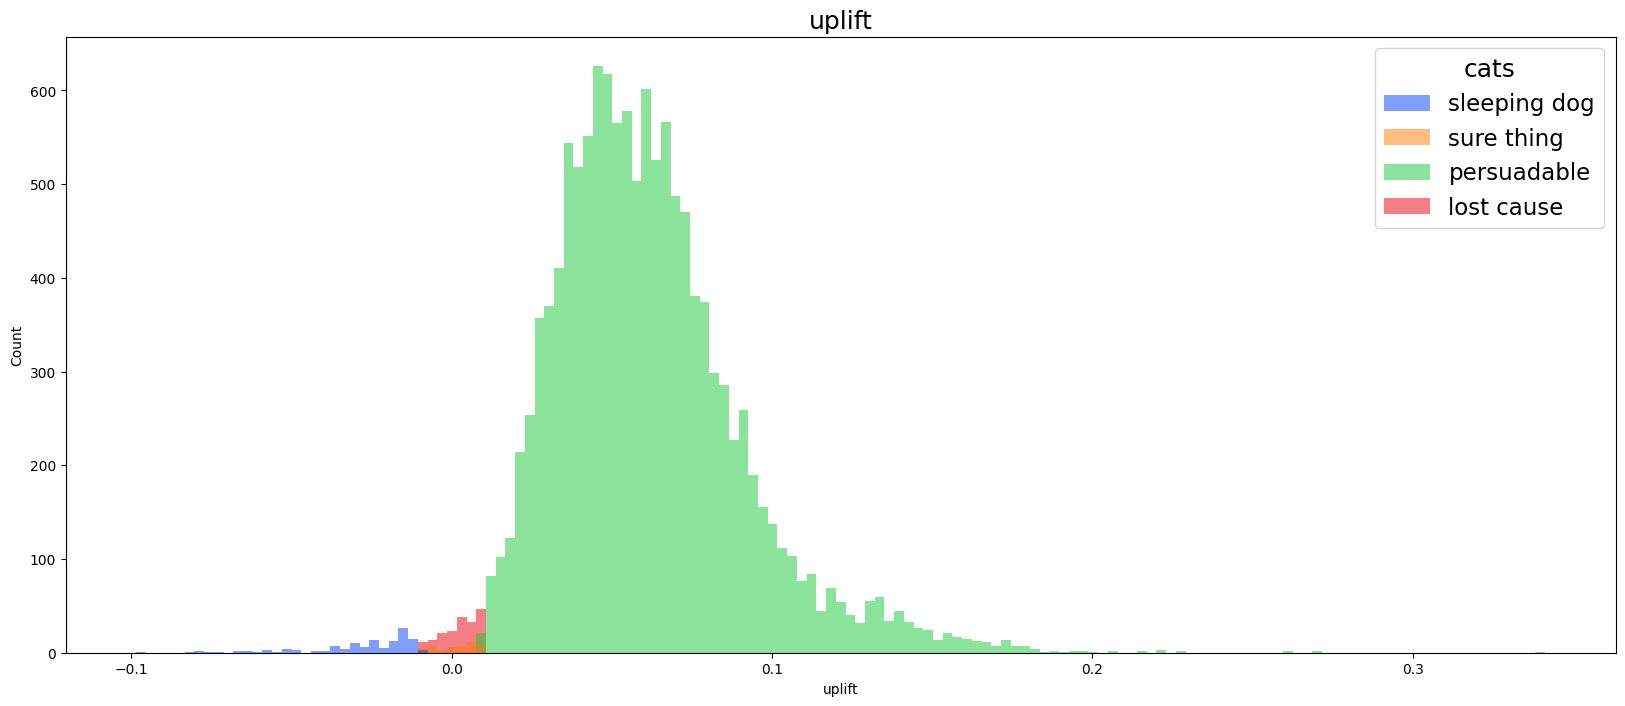

In [35]:
# uplift by category
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
    ax.set_title('uplift');